In [5]:
import pandas as pd
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sqlalchemy import create_engine

In [6]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'

In [8]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [24]:
oal_type_mapping = {
    'journal': {
        'editorial_discourse': ['erratum', 'editorial', 'letter', 'paratext', 'retraction'],
        'research_discourse': ['article', 'review'],
        'others': ['grant', 'book-chapter', 'dataset', 'book', 'other', 'reference-entry', 'dissertation', 
                   'report', 'peer-review', 'standard', 'book-series', 'supplementary-materials', 'Other']
    }
}

In [23]:
scp_type_mapping = {
    'journal': {
        'editorial_discourse': ['Erratum', 'Editorial', 'Letter', 'Note'],
        'research_discourse': ['Review', 'Article'],
        'others': ['Conference Paper', 'Chapter', 'Short Survey', 'Book', 'Tombstone', 'Data Paper', 'Article in Press', 
                   'Conference Review', 'Abstract Report', 'Business Article', 'getItemType: unmatched: pp', 'Report', 'Other']
    }
}

In [11]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [12]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height, v_gap_frac=0.09):
    df.fillna('None', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    l = dict()
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] = 0
        
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] += v2

    d_plot = {k: dict() for k in d.keys()}
    for k, v in d.items():
        for k2, v2 in v.items():
            d_plot[k][f'{k2}\n{l[k2]:,}'] = v2
            
    d_plot = {f'{k}\n{sum(v.values()):,}': v for k, v in d_plot.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d_plot, alpha=0.4, cmap=cmap, v_gap_frac=v_gap_frac, color_side=0, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [13]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height, v_gap_frac=0.045):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)
    df2.fillna('None', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    l = dict()
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] = 0
        
    for k, v in d.items():
        for k2, v2 in v.items():
            l[k2] += v2

    d_plot = {k: dict() for k in d.keys()}
    for k, v in d.items():
        for k2, v2 in v.items():
            d_plot[k][f'{k2}\n{l[k2]:,}'] = v2
            
    d_plot = {f'{k}\n{sum(v.values()):,}': v for k, v in d_plot.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d_plot, alpha=0.4, colors=['#C82E6B', '#65BADA', '#E5BA52', '#D86F27'], v_gap_frac=v_gap_frac, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [28]:
df = pd.read_csv('datasets/bquxjob_42993096_1916fdd98c3.csv')

In [29]:
df.head()

,n,oal_type,scp_type,wos_type
0,7003891,article,Article,Article
1,681761,review,Review,Review
2,292321,letter,Letter,Letter
3,153802,review,Article,Article
4,115205,article,Article,Editorial Material


In [30]:
df.loc[(df.scp_type == 'Abstract Report'), 'scp_type'] = 'Other'
df.loc[(df.scp_type == 'Business Article'), 'scp_type'] = 'Other'
df.loc[(df.scp_type == 'Article in Press'), 'scp_type'] = 'Other'
oal_scp_df = df.groupby(['oal_type', 'scp_type'])['n'].sum().reset_index()

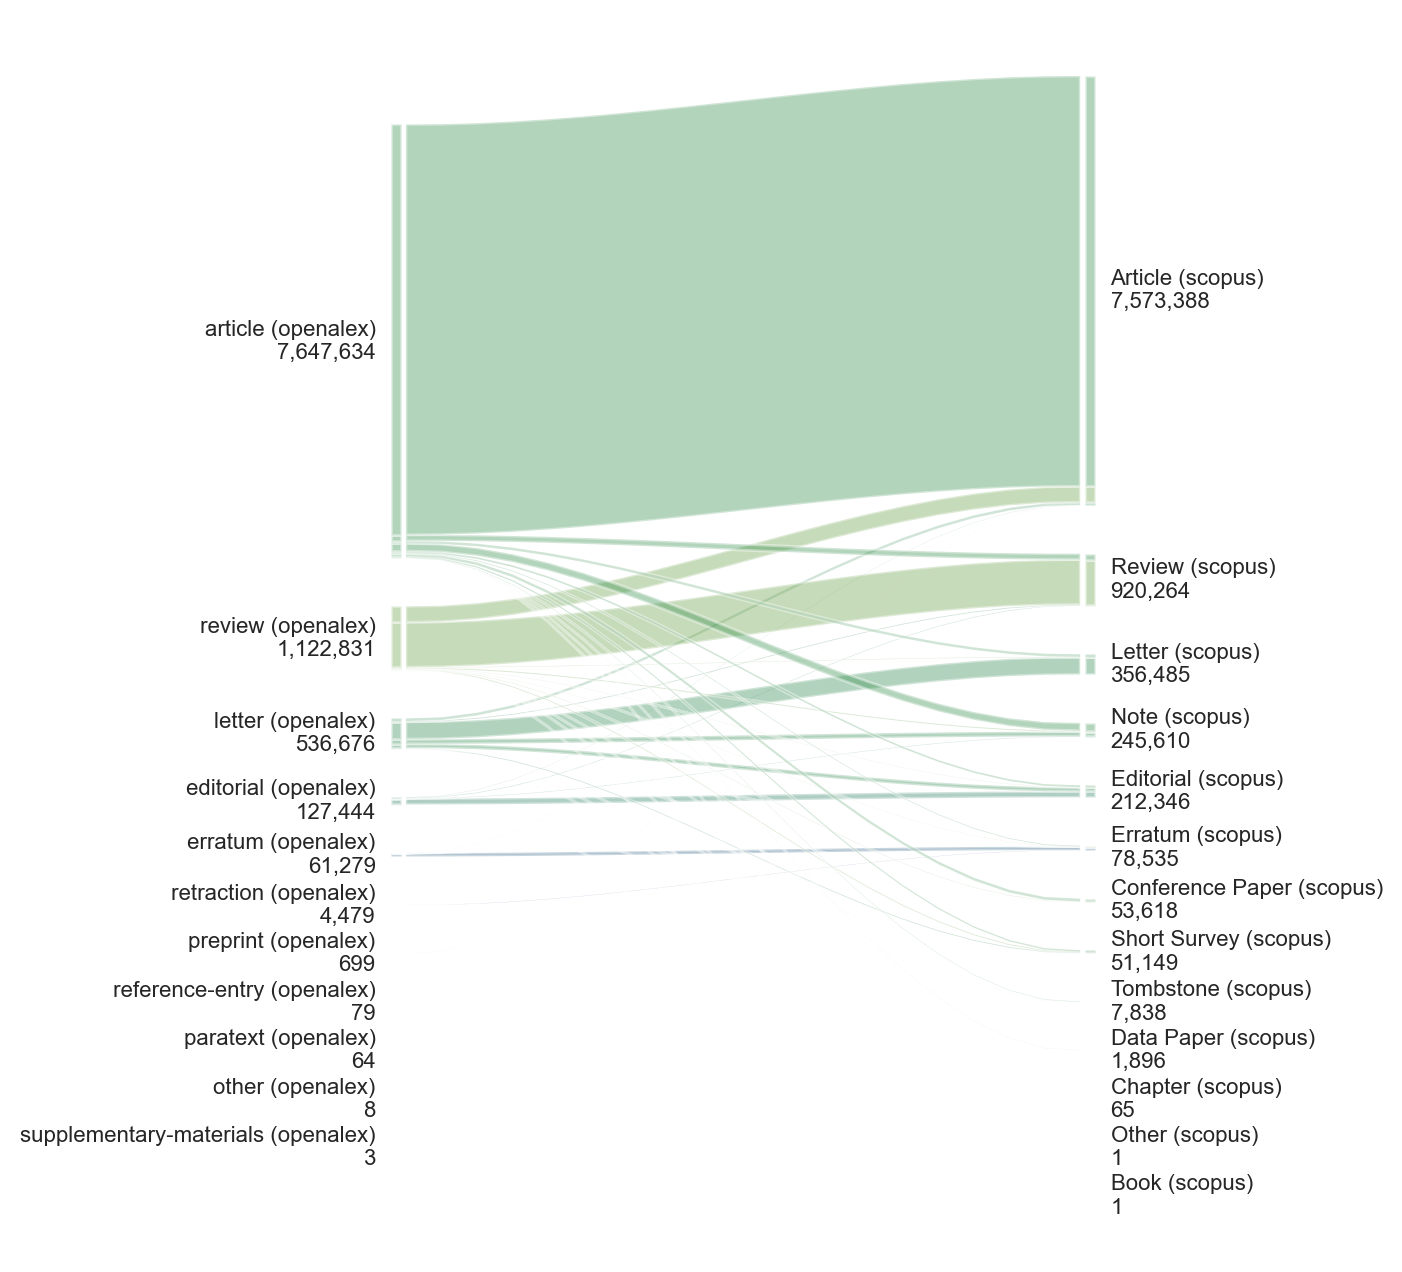

In [30]:
alluvial_plot(oal_scp_df, 'oal_type', 'scp_type', 'openalex', 'scopus', 'oal_scp_2024', 5, 8)

In [50]:
oal_wos_df = df.groupby(['oal_type', 'wos_type'])['n'].sum().reset_index()

In [51]:
oal_wos_df['wos_type'] = oal_wos_df.wos_type.str.split(',')

In [52]:
oal_wos_df = oal_wos_df.explode('wos_type')

In [53]:
oal_wos_df.loc[(oal_wos_df.wos_type == 'Retracted Publication'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Data Paper'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Meeting Abstract'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Book Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Reprint'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Expression of Concern'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'CC Meeting Heading'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Book Chapter'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Item Withdrawal'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Poetry'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Bibliography'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Software Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Hardware Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Film Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Theater Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Database Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Art Exhibit Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Record Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Dance Performance Review'), 'wos_type'] = 'Other'
oal_wos_df.loc[(oal_wos_df.wos_type == 'Meeting'), 'wos_type'] = 'Other'

oal_wos_df = oal_wos_df.groupby(['oal_type', 'wos_type'])['n'].sum().reset_index()

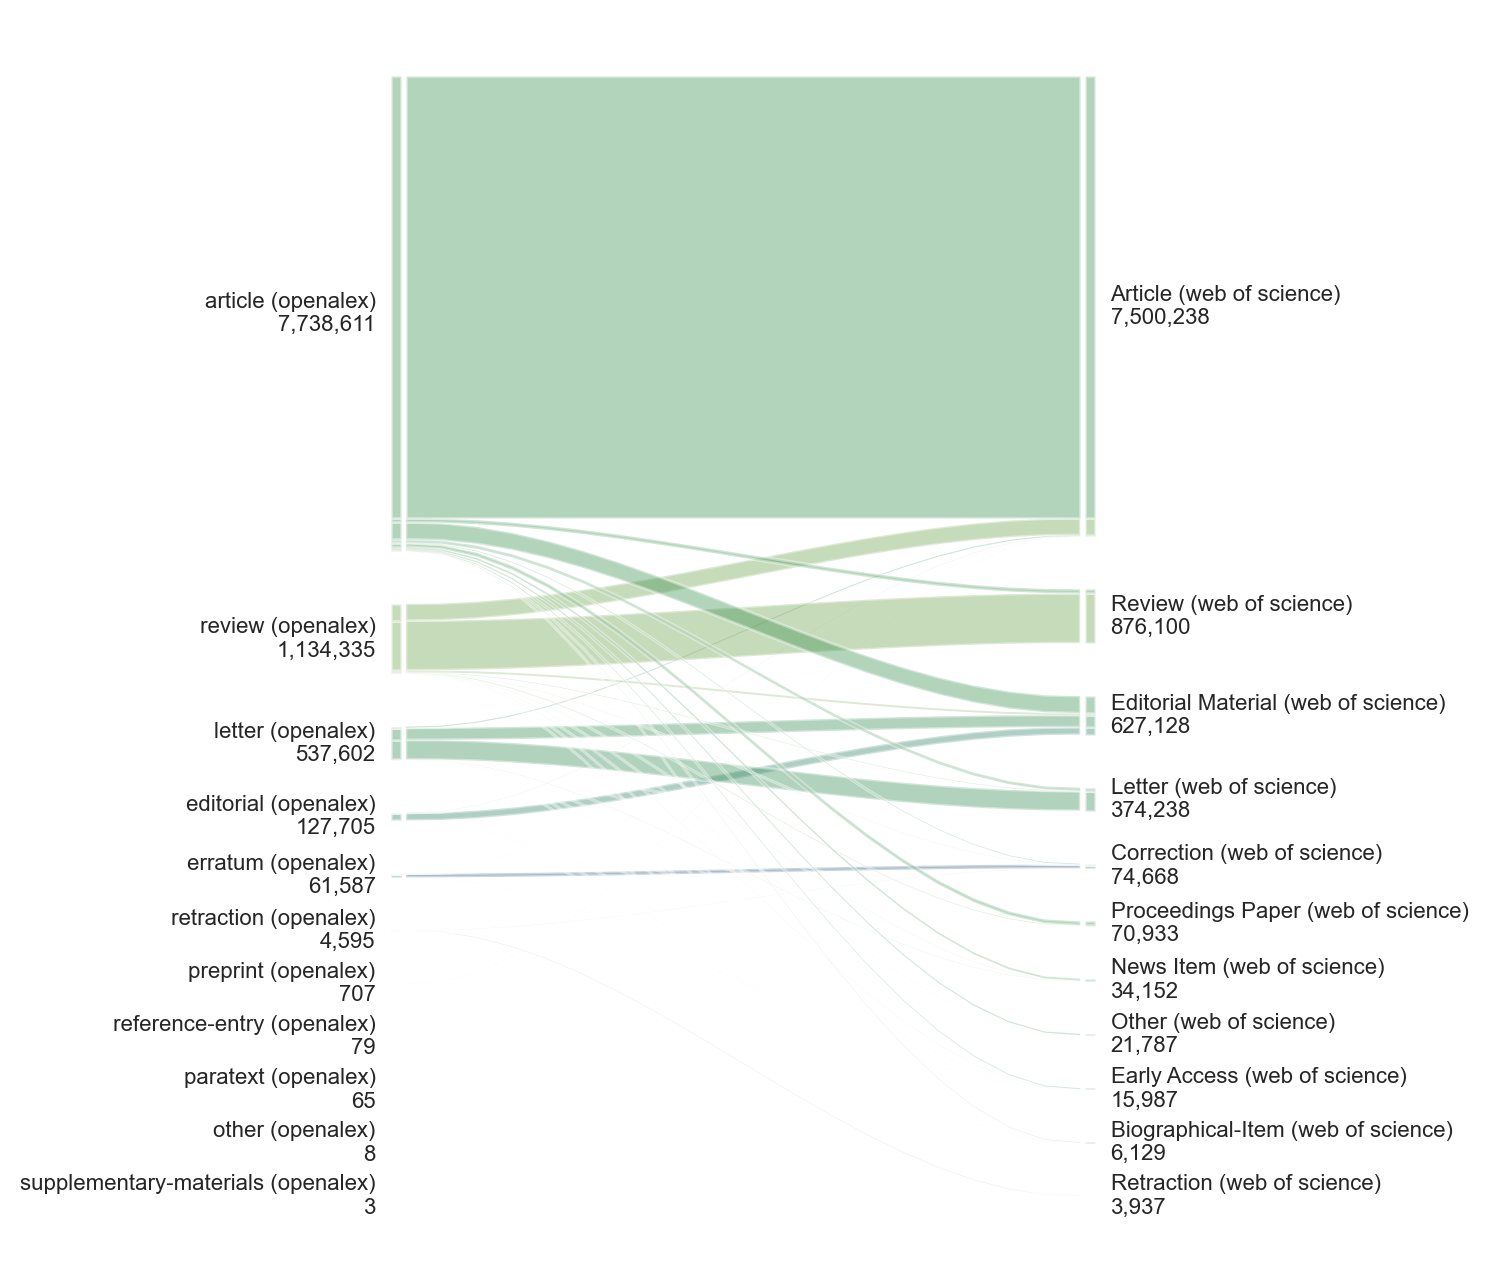

In [54]:
alluvial_plot(oal_wos_df, 'oal_type', 'wos_type', 'openalex', 'web of science', 'oal_wos_2024', 5, 8)

In [16]:
oal_scp_type = pd.read_sql("""
                         SELECT oal_type AS oal_type, unnest(item_type) AS scp_type, COUNT(DISTINCT(oal.doi)) AS n
                         FROM unignhaupka.oal_dois_2024 AS oal
                         JOIN scp_b_202404.items as scp
                             ON LOWER(oal.doi) = LOWER(scp.doi)
                         WHERE scp.source_type = 'Journal' AND scp.pubyear BETWEEN 2012 AND 2022
                         GROUP BY oal_type, scp_type
                         """, 
                         con=engine)

In [17]:
oal_scp_type.loc[(oal_scp_type.scp_type == 'Abstract Report'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scp_type == 'Business Article'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scp_type == 'Article in Press'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scp_type == 'Conference Review'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scp_type == 'Report'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.scp_type == 'Book'), 'scp_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'book'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'report'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'dataset'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'supplementary-materials'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'dissertation'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'book-chapter'), 'oal_type'] = 'Other'
oal_scp_type.loc[(oal_scp_type.oal_type == 'other'), 'oal_type'] = 'Other'
oal_scp_type = oal_scp_type.groupby(['oal_type', 'scp_type'])['n'].sum().reset_index()

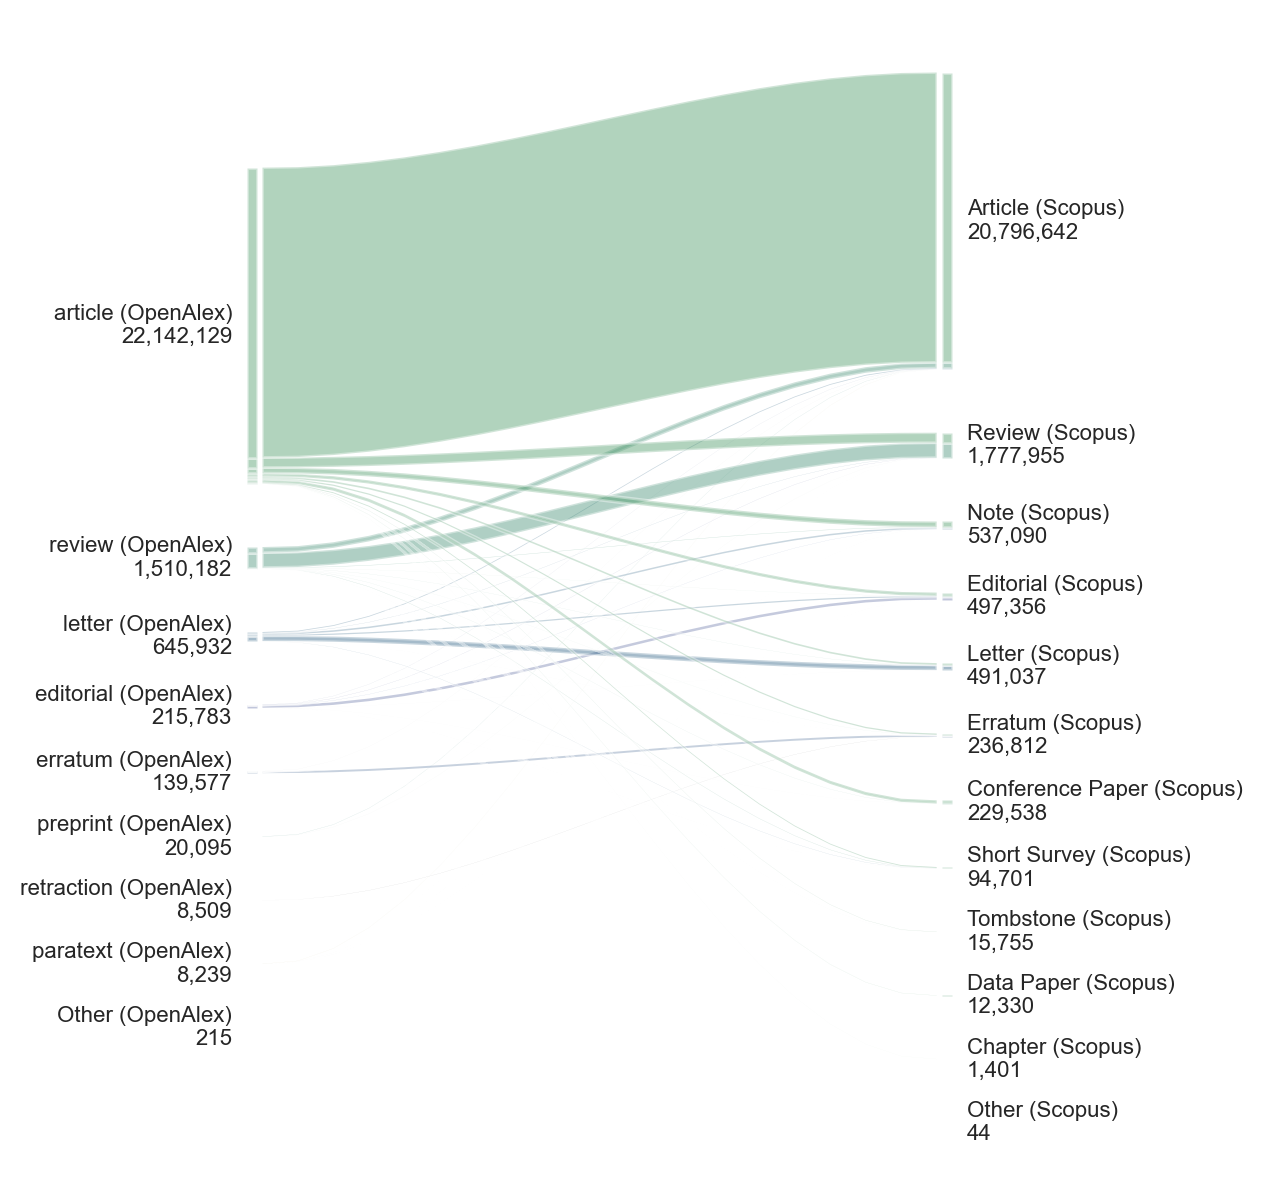

In [18]:
alluvial_plot(oal_scp_type, 'oal_type', 'scp_type', 'OpenAlex', 'Scopus', 'oal_scp_type_2024', 5, 7.5, 0.18)

In [34]:
oal_scp_new_type = oal_scp_type.copy()
#oal_scp_new_type = df.copy()

In [35]:
scp_types_new = oal_scp_new_type.copy()
scp_types_new['scp_new_type'] = scp_types_new.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_type']), axis=1)
scp_types_new = scp_types_new.groupby(['scp_new_type'])['n'].sum().reset_index()
scp_types_new['prop'] = (scp_types_new['n'] / scp_types_new['n'].sum()) * 100
scp_types_new

,scp_new_type,n,prop
0,editorial_discourse,1762295,7.137496
1,others,353769,1.432805
2,research_discourse,22574597,91.429699


In [36]:
oal_types_new = oal_scp_new_type.copy()
oal_types_new['oal_new_type'] = oal_types_new.apply(lambda row : mapping_types(oal_type_mapping['journal'], row['oal_type']), axis=1)
oal_types_new = oal_types_new.groupby(['oal_new_type'])['n'].sum().reset_index()
oal_types_new['prop'] = (oal_types_new['n'] / oal_types_new['n'].sum()) * 100
oal_types_new

,oal_new_type,n,prop
0,editorial_discourse,1018040,4.126537
1,others,215,0.000871
2,research_discourse,23652311,95.872592
